In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import pylab as pl
from matplotlib import collections as mc
import time

In [2]:
from numba import cuda
from numba import *
from numba import jit

In [3]:
np.random.seed(1337)

In [4]:
# Load data
cities = pd.read_csv("cities.csv")
sample = pd.read_csv("sample_submission.csv")

In [5]:
# Testing with a subset of cities (355 cities out of 197769)
city_subset = cities[(cities.X < 500) & (cities.Y < 500)]

In [6]:
# Plots the path
def plot_tour(cities, path, endpoint=None):
    lines = [[(cities.X[path[i]],cities.Y[path[i]]),(cities.X[path[i+1]],cities.Y[path[i+1]])] for i in range(0,len(cities)-1)]
    lc = mc.LineCollection(lines, linewidths=2)
    fig, ax = pl.subplots(figsize=(20,20))
    ax.set_aspect('equal')
    ax.add_collection(lc)
    ax.autoscale()

In [7]:
# Find our primes, we were able to achieve 10x speedup with numba
@jit(nopython=True, error_model='numpy', fastmath=True, parallel=True)
def numba_sieve_of_eratosthenes(n):
    primes = [True for i in range(n+1)] # Start assuming all numbers are primes
    primes[0] = False # 0 is not a prime
    primes[1] = False # 1 is not a prime
    for i in range(2,int(np.sqrt(n)) + 1):
        if primes[i]:
            k = 2
            while i*k <= n:
                primes[i*k] = False
                k += 1
    return(primes)

PRIMES = numba_sieve_of_eratosthenes(len(cities))

In [8]:
# Fitness function, calculates total distance of a path, including prime penalty
def total_distance(city_df, path):
    prev_city = path[0]
    total_distance = 0
    step_num = 1

    for city_num in path[1:]:
        next_city = city_num
        
        x2 = np.power((city_df.X[city_num] - city_df.X[prev_city]),2)
        y2 = np.power((city_df.Y[city_num] - city_df.Y[prev_city]),2)
        city1 = [city_df.X[city_num], city_df.Y[city_num]]
        city1 = [city_df.X[city_num], city_df.Y[city_num]]
        dist = np.sqrt(x2 + y2)
        
        is_prime = PRIMES[prev_city]
        is_tenth_step = step_num % 10 == 0
        
    ## prime penalty: if the 10th city isn't a prime, edge 10-11 is 10% longer
        penalty = 1 + is_tenth_step * 0.1 * (not(is_prime))
        
        total_distance += dist * penalty
        
        prev_city = next_city
        step_num += 1
        
    return total_distance

In [9]:
# Randomly swaps pairs of nodes around the path as a way to initialize the starting solution
@jit(nopython=True, error_model='numpy', fastmath=True, parallel=True)
def random_permutation(cities, start_city=None):
    ''' TODO: add in end_city (?) '''
    
    perm = cities
    
    for i in range(len(perm)):
        r = np.random.randint(0, high=len(perm)-i) + i
        perm[r], perm[i] = perm[i], perm[r] # swaps two cities
        
    return perm # new path with random pairs swapped

In [10]:
# Checks whether an edge is in the tabu list
def is_tabu(perm, tabu_list):
    for i in range(len(perm)):
        c1 = perm[i] # city 1
        if i == len(perm)-1:
            c2 = perm[0]
        else:
            c2 = perm[i+1]
    
        if [c1,c2] in tabu_list:
            return True
  
    return False

In [11]:
# Randomly crosses two edges and returns the resulting path
@jit(nopython=True, error_model='numpy', fastmath=True, parallel=True)
def stochastic_two_opt(parent):
    
    perm = parent
    
    c1 = np.random.randint(len(perm))
    c2 = np.random.randint(len(perm))
    
    exclude = [c1]
    
    if c1 == 0:
        exclude.append(len(perm)-1)
    else:
        exclude.append(c1-1)
        
    if c1 == len(perm)-1:
        exclude.append(0)
    else:
        exclude.append(c1+1)
    
    while c2 in exclude:
        c2 = np.random.randint(len(perm))
        if c2 < c1:
            c1, c2 = c2, c1 # now c1 < c2
            perm = two_opt_swap(perm, c1, c2)
    
    return perm, [ [ parent[c1-1], parent[c1] ], [ parent[c2-1], parent[c2] ] ] # returns new path, edges that were crossed

@jit(nopython=True, error_model='numpy', fastmath=True, parallel=True)
def two_opt_swap(path, i, k):
    ''' TODO: Replace this with the Lin-Kernighan algorithm, which Concorde uses.
        LKH swaps sub-paths, adapatively decides how many paths need to be swapped every step. '''
    
    new_path = path[:]
    new_path[i:k] = path[k-1:i-1:-1]
    return new_path

In [12]:
def generate_candidate(best_path, tabu_list, cities):

    perm = best_path
    edges = [[0,0]], [[0,0]]
    
    tabu = True
    while tabu:
        perm, edges = stochastic_two_opt(best_path)
        tabu = is_tabu(perm, tabu_list)
    
    perm_distance = total_distance(cities, perm)
    return [perm_distance, perm, edges]

In [13]:
# Calculate candidate with shortest distance
def get_best_candidate(candidates):
    cost, best = None, None
    
    for perm_distance, perm, edges in candidates:
        if cost is None:
            cost = perm_distance
            best = [perm_distance, perm, edges]
            
        if perm_distance < cost:
            best = [perm_distance, perm, edges]
            
    return best

In [14]:
def tabu_search(cities, path, tabu_list_size, max_candidates, max_iter, start_city):

    perm = path
    perm = np.delete(perm, np.where(perm == start_city), axis=0)
    best_path = random_permutation(perm, start_city)
    perm = np.insert(perm, 0, start_city, axis=0)

    best_cost = total_distance(cities, best_path)
    
    tabu_list = []
    
    for i in range(max_iter):
        candidates = []
        for j in range(max_candidates):
            candidates.append(generate_candidate(best_path, tabu_list, cities))
            best_candidate = get_best_candidate(candidates)
            
            candidate_cost = best_candidate[0]
            candidate_path = best_candidate[1]
            candidate_edges = best_candidate[2]
            
            if candidate_cost < best_cost:
                best_cost = candidate_cost
                best_path = candidate_path
                
                for edge in candidate_edges:
                    tabu_list.append(edge)
                
                while len(tabu_list) > tabu_list_size:
                    tabu_list.pop(0)
        
    return best_cost, best_path

In [18]:
# Set optimization hyperparameters and optimize

max_iter = 100
tabu_list_size = 15
max_candidates = 10

best_cost, best_path = tabu_search(cities, city_subset.CityId.values, tabu_list_size, max_candidates, max_iter, 0)

In [23]:
import timeit
timeit.timeit('tabu_search(cities, city_subset.CityId.values, tabu_list_size, max_candidates, max_iter, 0)', globals=globals() , number=1)

43.03766743899905

### Improving runtime

Rewriting most of the above functions to work with numba reduced runtime by ~500x. Numba doesn't play well with dataframes or lists; can probably get more speed-up if we rewrite the lists as numpy arrays, but there isn't a good workaround for dataframes.

In [19]:
print('Path distance of cities in order they were listed:', total_distance(cities, city_subset.CityId.values))
print('Path distance of tabu search optimized route:', best_cost)

Path distance of cities in order they were listed: 85752.48949926025
Path distance of tabu search optimized route: 83209.3892763709


### Improving solution

The tabu optimized solution (distance = 83209) offers a slight improvement over the default path taken through cities in the order they were listed (distance = 85752). We ran 100 iteration with 10 trial candidates per iteration.

The next step is using tabu search to further optimize and add prime-corrected distance calculation on top of the Concorde solution.

#### Default path taken through cities in order they were listed

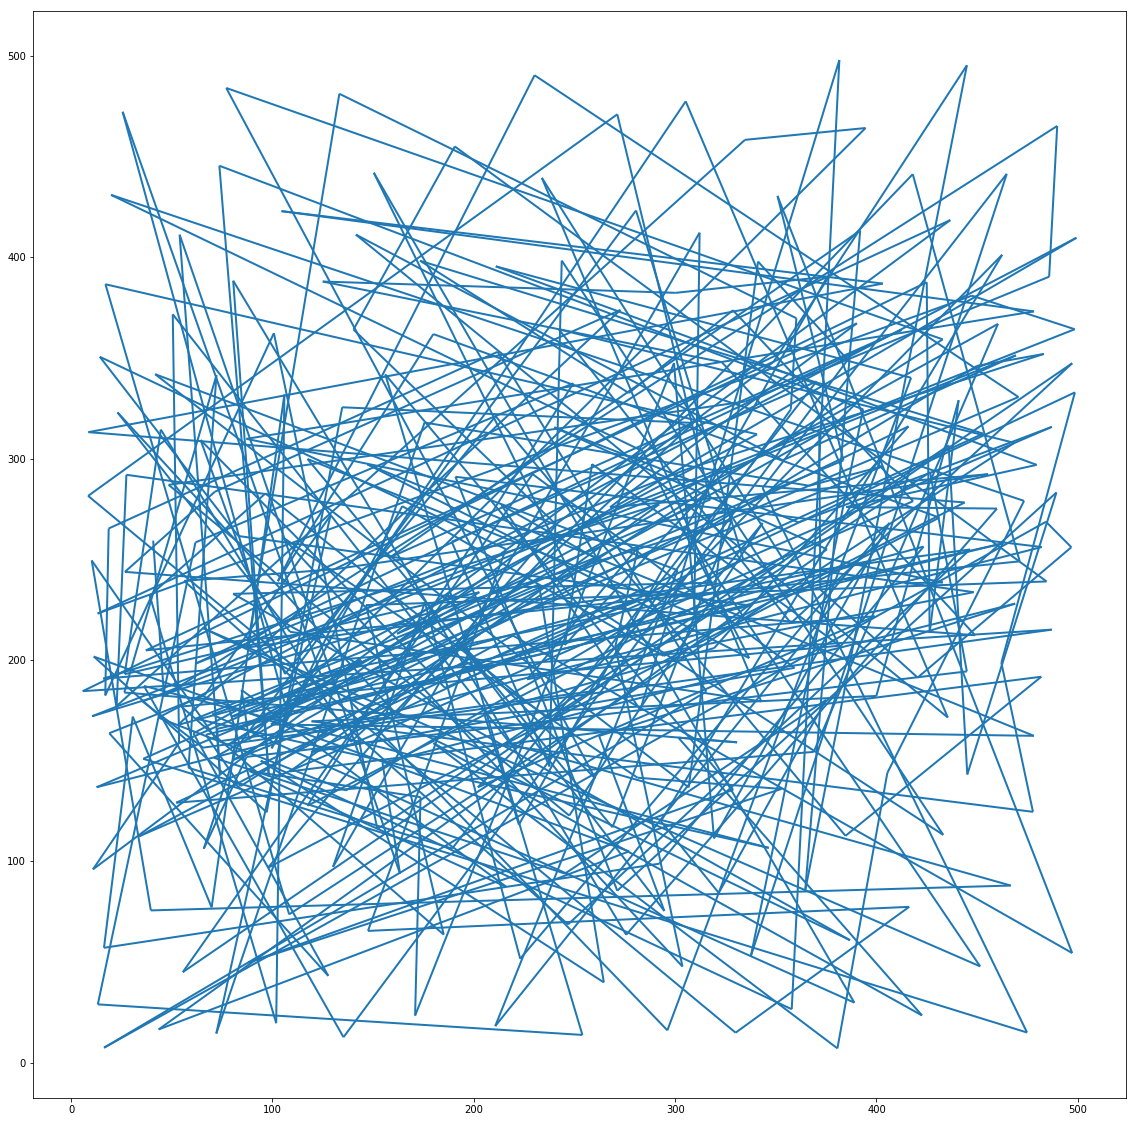

In [20]:
plot_tour(city_subset, city_subset.CityId.values)

#### Tabu optimized path

Even though this is probably far from the best possible path, it already looks a bit cleaner (less dense) than the default path.

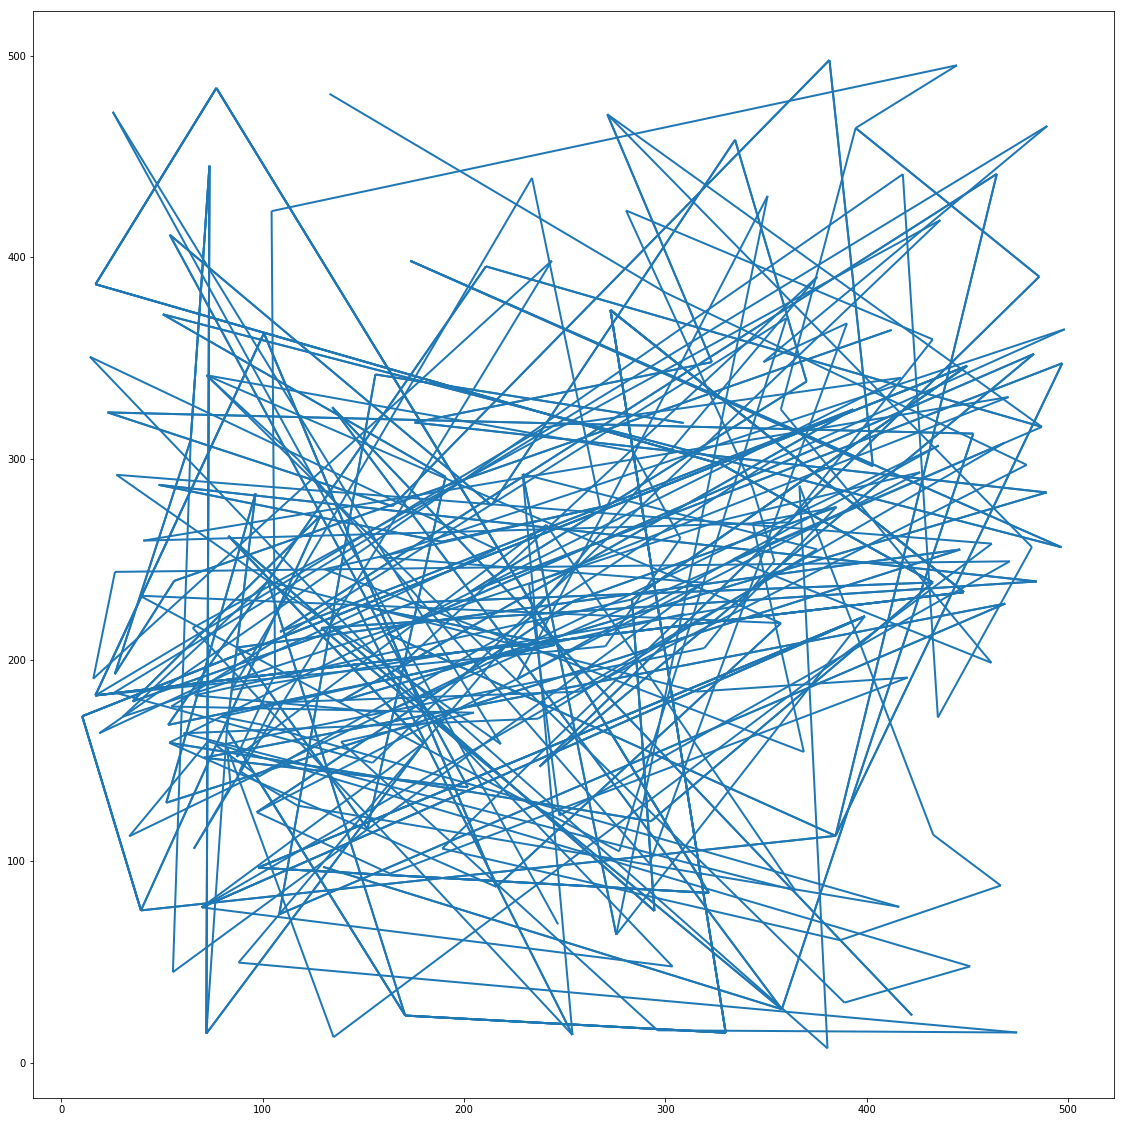

In [22]:
plot_tour(city_subset, best_path)